##  Урок 5. Домашнее задание

<ol>
    <li>Попробуйте обучить нейронную сеть LSTM на любом другом датасете (любимый временной ряд, текст на русском (другом языке) как генератор или классификатор, или прилагаемый набор airline-passengers - пасажиропоток для авиалиний). Опишите, какой результата вы получили? Что помогло вам улучшить ее точность?

    
<li>*Попробуйте на numpy реализовать нейронную сеть архитектуры LSTM</li>
<li>*Предложите свои варианты решения проблемы исчезающего градиента в RNN</li>
</ol>

__Задание 1.__

In [3]:
import numpy as np
import pandas as pd
import tensorflow.keras as keras
import seaborn as sns
import os
import datetime


from matplotlib import pyplot as plt
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

from google.colab import files
from sklearn.preprocessing import StandardScaler, MinMaxScaler

%matplotlib inline

В качестве датасета возьмем временной ряд со значениями индекса РТС в промежутке с 2011 года по текущий момент с сайта Московской биржи.

In [4]:
df = pd.read_csv('security.csv', sep=';', encoding='cp1251', header=1)
df.head()

,BOARDID,SECID,TRADEDATE,SHORTNAME,NAME,CLOSE,OPEN,HIGH,LOW,VALUE,DURATION,YIELD,DECIMALS,CAPITALIZATION,CURRENCYID,DIVISOR,TRADINGSESSION,VOLUME
0,RTSI,RTSI,11.01.2011,Индекс РТС,Индекс РТС,"1802,23","1770,27","1802,23","1767,8","334401753,0903",NaN,NaN,2,"189954306384,263",USD,"999999,999999",3,NaN
1,RTSI,RTSI,12.01.2011,Индекс РТС,Индекс РТС,"1868,94","1802,23","1868,94","1800,24","477669596,6062",NaN,NaN,2,"196985476834,621",USD,"999999,999999",3,NaN
2,RTSI,RTSI,13.01.2011,Индекс РТС,Индекс РТС,"1878,14","1868,94","1887,59","1865,91","574328590,5658",NaN,NaN,2,"197955018735,781",USD,"999999,999999",3,NaN
3,RTSI,RTSI,14.01.2011,Индекс РТС,Индекс РТС,"1870,09","1879,3","1884,84","1860,28","470996048,0009",NaN,NaN,2,"197106414413,145",USD,"999999,999999",3,NaN
4,RTSI,RTSI,17.01.2011,Индекс РТС,Индекс РТС,"1901,61","1870,09","1906,83","1870,09","486921332,0462",NaN,NaN,2,"200429110946,233",USD,"999999,999999",3,NaN


В рамках построения модели будем работать с итоговыми значениями индекса РТС за день.

In [5]:
df = df[['TRADEDATE', 'CLOSE']]
df.set_index('TRADEDATE', inplace=True)
df.head()

,CLOSE
TRADEDATE,
11.01.2011,"1802,23"
12.01.2011,"1868,94"
13.01.2011,"1878,14"
14.01.2011,"1870,09"
17.01.2011,"1901,61"


Проведем необходимые преобразования значений и дат.

In [6]:
df.index = pd.to_datetime(df.index, format='%d.%m.%Y')
df.head()

,CLOSE
TRADEDATE,
2011-01-11,"1802,23"
2011-01-12,"1868,94"
2011-01-13,"1878,14"
2011-01-14,"1870,09"
2011-01-17,"1901,61"


In [7]:
df['CLOSE'] = df['CLOSE'].str.replace(',' ,'.').astype('float32')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2780 entries, 2011-01-11 to 2022-01-19
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CLOSE   2780 non-null   float32
dtypes: float32(1)
memory usage: 32.6 KB


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


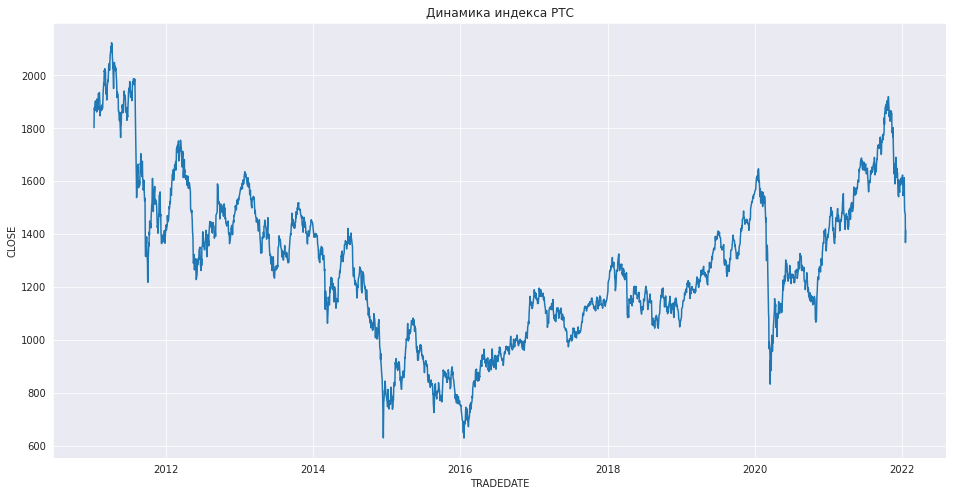

In [8]:
plt.figure(figsize=(16,8))
sns.set_style("darkgrid")
sns.lineplot(data=df, x=df.index, y='CLOSE')
plt.title('Динамика индекса РТС')
plt.grid('On')
plt.show()

Нормализуем данные.

In [9]:
df['day'] = pd.to_datetime(df.index).dayofyear/366.0
df['year'] = pd.to_datetime(df.index).year - 2011
df.head()

,CLOSE,day,year
TRADEDATE,,,
2011-01-11,1802.229980,0.030055,0
2011-01-12,1868.939941,0.032787,0
2011-01-13,1878.140015,0.035519,0
2011-01-14,1870.089966,0.038251,0
2011-01-17,1901.609985,0.046448,0


In [10]:
data = pd.DataFrame(MinMaxScaler().fit_transform(df), columns=df.columns)
data.head()

,CLOSE,day,year
0,0.785085,0.022099,0.0
1,0.829703,0.024862,0.0
2,0.835856,0.027624,0.0
3,0.830472,0.030387,0.0
4,0.851553,0.038674,0.0


In [11]:
# список признаков, по которым будем учить
channelIndexes = [0, 1, 2]

# длина теста
valLen = 200
# длина истории для работы
xLen = 7
# отступ тестов от тренировок
bias = 10

# вычисляем точку разделения ряда на тесты и тренировку
train_split = data.shape[0] - valLen - bias
# делим
train_data = data.iloc[0 : train_split ,channelIndexes]
val_data = data.iloc[train_split+bias:,channelIndexes]

Размер обучающей и валидационной выборок:

In [12]:
train_data.shape

(2570, 3)

In [13]:
val_data.shape

(200, 3)

In [14]:
# шаг по данным для построения обучающих примеров
step = 1

# длина прошлого 
past = xLen
p = past
# горизонт предсказания
future = 1
h=future

# параметры модели для обучения
learning_rate = 1e-3
batch_size = 32
epochs = 100


In [15]:
Chanel_numb = len(channelIndexes)

start = xLen + future
end = start + train_split-1

xTrain_df = train_data.iloc[:-future-xLen+1,:] # сдвиг по времени для предсказания (закончить чуть раньше)
xTrain = xTrain_df[[train_data.columns[i] for i in range(Chanel_numb)]].values
yTrain = train_data.iloc[future+xLen-1:,0].values  # сдвиг по времени для предсказания (начать чуть позднее)

sequence_length = int(xLen / step)


x_end = len(val_data) - xLen - future 

label_start = len(train_data)+bias+xLen + future +1

xVal_df = val_data.iloc[:-future-xLen+1,:] # сдвиг по времени для предсказания (закончить чуть раньше)
xVal = xVal_df[[val_data.columns[i] for i in range(Chanel_numb)]].values
yVal = val_data.iloc[future+xLen-1:,0].values  # сдвиг по времени для предсказания (начать чуть позднее)

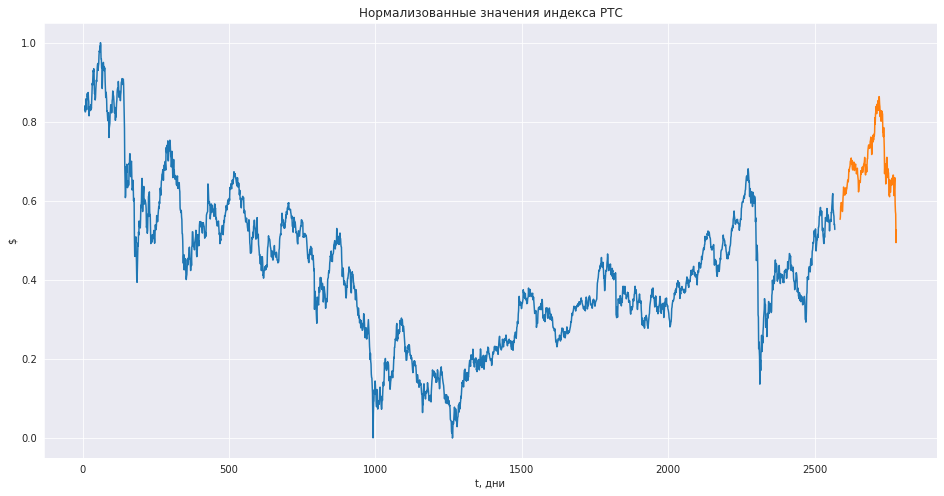

In [16]:
plt.figure(figsize=(16,8))
plt.plot(data.index[xLen:yTrain.shape[0]+xLen],yTrain[:])
plt.plot(data.index[yTrain.shape[0]+bias+future+2*xLen-1:],yVal[:])
plt.grid('on')
plt.xlabel('t, дни')
plt.ylabel('$')
plt.title('Нормализованные значения индекса РТС')
plt.show()

В соответствии с представленным на лекции подходом создаем пакеты для обучения нейронной сети.

In [17]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    xTrain,
    yTrain,
    sequence_length=xLen,
    sampling_rate=1,
    batch_size=batch_size,
)
dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    xVal,
    yVal,
    sequence_length=xLen,
    sampling_rate=1,
    batch_size=batch_size,
)


In [18]:
for batch in dataset_val.take(2):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (32, 7, 3)
Target shape: (32,)


In [19]:
logdir = os.path.join("logs2", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard( logdir, histogram_freq=1)

Наилучшие результаты по метрике показывает довольно простая модель.

Epoch 1/100
80/80 [==============================] - 4s 17ms/step - loss: 0.1179 - mae: 0.2437 - val_loss: 0.0330 - val_mae: 0.1746
Epoch 2/100
80/80 [==============================] - 1s 12ms/step - loss: 0.0393 - mae: 0.1499 - val_loss: 0.0394 - val_mae: 0.1934
Epoch 3/100
80/80 [==============================] - 1s 12ms/step - loss: 0.0268 - mae: 0.1253 - val_loss: 0.0270 - val_mae: 0.1598
Epoch 4/100
80/80 [==============================] - 1s 12ms/step - loss: 0.0175 - mae: 0.1035 - val_loss: 0.0165 - val_mae: 0.1242
Epoch 5/100
80/80 [==============================] - 1s 16ms/step - loss: 0.0119 - mae: 0.0864 - val_loss: 0.0098 - val_mae: 0.0942
Epoch 6/100
80/80 [==============================] - 1s 14ms/step - loss: 0.0086 - mae: 0.0741 - val_loss: 0.0060 - val_mae: 0.0727
Epoch 7/100
80/80 [==============================] - 1s 17ms/step - loss: 0.0066 - mae: 0.0652 - val_loss: 0.0040 - val_mae: 0.0581
Epoch 8/100
80/80 [==============================] - 1s 13ms/step - loss: 0.

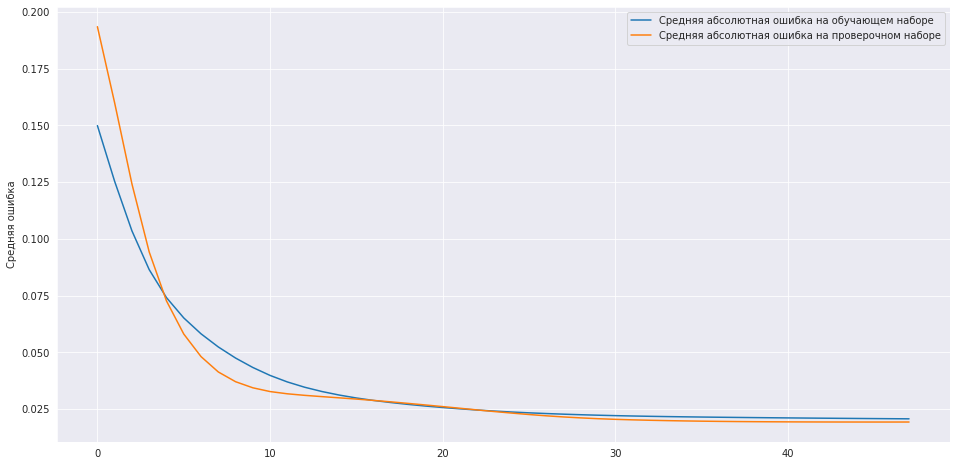

In [27]:
callbaсk = EarlyStopping(monitor='val_mae', patience=2)

model = Sequential()

model.add(LSTM(5, input_shape = (inputs.shape[1], inputs.shape[2]), return_sequences="True"))
model.add(Flatten())                       
model.add(Dense(2, activation="linear"))   
model.add(Dense(1, activation="linear"))

model.compile(loss="mse", optimizer="adam", metrics=['mae'])

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[callbaсk, tensorboard_callback])

plt.figure(figsize=(16, 8))
plt.plot(history.history['mae'][1:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'][1:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [28]:
pred = model.predict(dataset_train).flatten()
predVal = model.predict(dataset_val).flatten()

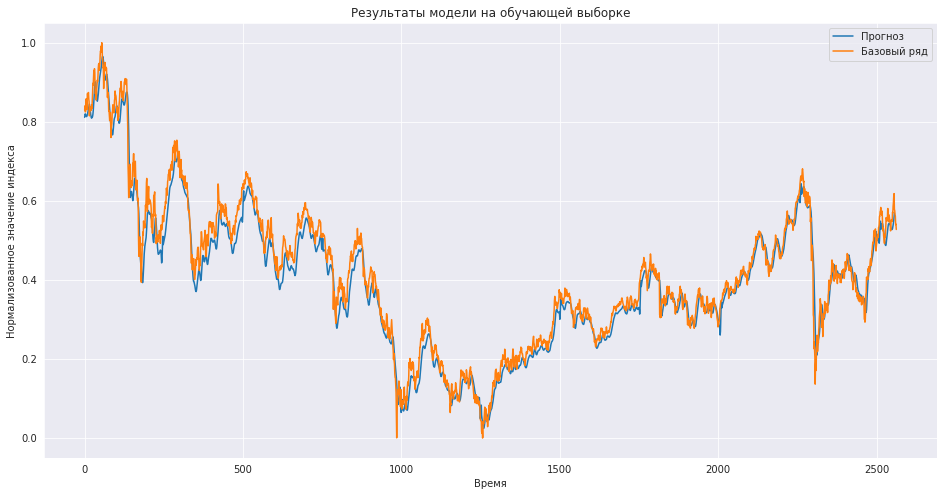

In [29]:
start = 0
plt.figure(figsize=(16,8))
plt.grid('on')
plt.plot(pred[start:train_split], 
         label='Прогноз')
plt.plot(yTrain.flatten()[start:train_split], 
         label='Базовый ряд')
plt.title('Результаты модели на обучающей выборке')
plt.xlabel('Время')
plt.ylabel('Нормализованное значение индекса')
plt.legend()
plt.show()

Несмотря на то, что ошибка получилась довольно маленькой прогноз на тестовой выборке получается уже не очень хорошим, с лагом. Это же видно и в лаговой корреляции, что максимальное значение достигается не у нулевого значения.

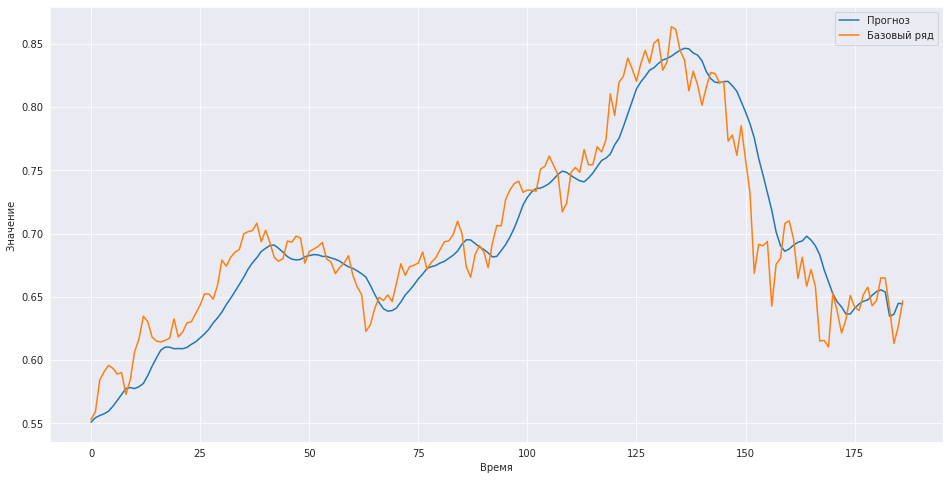

In [30]:
start = 0
step = predVal.shape[0]
plt.figure(figsize=(16,8))
plt.grid('on')
plt.plot(predVal[start:start+step], 
         label='Прогноз')
plt.plot(yVal.flatten()[start:start+step], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

In [31]:
def correlate(a, b):
  ma = a.mean()
  mb = b.mean()
  mab = (a*b).mean()
  sa = a.std()
  sb = b.std()
  
  val = 0
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val

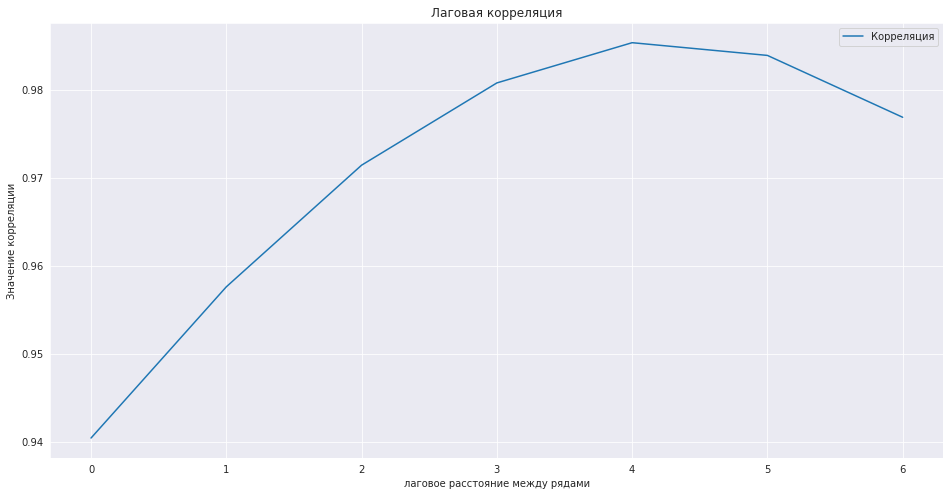

In [32]:
corr = []
start = 0 
step = predVal.shape[0]
h=0
yLen = yVal.shape[0]
yValF = yVal[start:start+step].flatten() 
yPredVal = predVal[start:start+step]

for i in range(7):
  corr.append(correlate(yValF[:-1-i], yPredVal[i:-1]))

plt.figure(figsize=(16,8))
plt.plot(corr, 
         label='Корреляция')
plt.xlabel('лаговое расстояние между рядами')
plt.ylabel('Значение корреляции')
plt.title('Лаговая корреляция')
plt.legend()
plt.show()

In [33]:
corr

[0.9404219374706212,
 0.9576261308986138,
 0.971468123712502,
 0.9808278160535989,
 0.9854063739665813,
 0.9839587621213237,
 0.9769197667401983]

Длина истории = 1:

In [34]:
# список признаков, по которым будем учить
channelIndexes = [0, 1, 2]

# длина теста
valLen = 200
# длина истории для работы
xLen = 1
# отступ тестов от тренировок
bias = 10

# вычисляем точку разделения ряда на тесты и тренировку
train_split = data.shape[0] - valLen - bias
# делим
train_data = data.iloc[0 : train_split ,channelIndexes]
val_data = data.iloc[train_split+bias:,channelIndexes]

In [35]:
# шаг по данным для построения обучающих примеров
step = 1

# длина прошлого 
past = xLen
p = past
# горизонт предсказания
future = 1
h=future

# параметры модели для обучения
learning_rate = 1e-3
batch_size = 32
epochs = 100


Chanel_numb = len(channelIndexes)

start = xLen + future
end = start + train_split-1

xTrain_df = train_data.iloc[:-future-xLen+1,:] # сдвиг по времени для предсказания (закончить чуть раньше)
xTrain = xTrain_df[[train_data.columns[i] for i in range(Chanel_numb)]].values
yTrain = train_data.iloc[future+xLen-1:,0].values  # сдвиг по времени для предсказания (начать чуть позднее)

sequence_length = int(xLen / step)


x_end = len(val_data) - xLen - future 

label_start = len(train_data)+bias+xLen + future +1

xVal_df = val_data.iloc[:-future-xLen+1,:] # сдвиг по времени для предсказания (закончить чуть раньше)
xVal = xVal_df[[val_data.columns[i] for i in range(Chanel_numb)]].values
yVal = val_data.iloc[future+xLen-1:,0].values  # сдвиг по времени для предсказания (начать чуть позднее)

In [39]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    xTrain,
    yTrain,
    sequence_length=xLen,
    sampling_rate=1,
    batch_size=batch_size,
)
dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    xVal,
    yVal,
    sequence_length=xLen,
    sampling_rate=1,
    batch_size=batch_size,
)

for batch in dataset_val.take(2):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (32, 1, 3)
Target shape: (32,)


Хорошие ошибки, но снова проблемы с лаговой корреляцией:

Epoch 1/100
81/81 [==============================] - 3s 16ms/step - loss: 0.1006 - mae: 0.2205 - val_loss: 0.0349 - val_mae: 0.1790
Epoch 2/100
81/81 [==============================] - 1s 11ms/step - loss: 0.0329 - mae: 0.1394 - val_loss: 0.0270 - val_mae: 0.1554
Epoch 3/100
81/81 [==============================] - 1s 11ms/step - loss: 0.0243 - mae: 0.1207 - val_loss: 0.0174 - val_mae: 0.1209
Epoch 4/100
81/81 [==============================] - 1s 12ms/step - loss: 0.0175 - mae: 0.1032 - val_loss: 0.0105 - val_mae: 0.0910
Epoch 5/100
81/81 [==============================] - 1s 12ms/step - loss: 0.0123 - mae: 0.0877 - val_loss: 0.0062 - val_mae: 0.0686
Epoch 6/100
81/81 [==============================] - 1s 12ms/step - loss: 0.0083 - mae: 0.0730 - val_loss: 0.0038 - val_mae: 0.0526
Epoch 7/100
81/81 [==============================] - 1s 10ms/step - loss: 0.0054 - mae: 0.0590 - val_loss: 0.0024 - val_mae: 0.0418
Epoch 8/100
81/81 [==============================] - 1s 13ms/step - loss: 0.

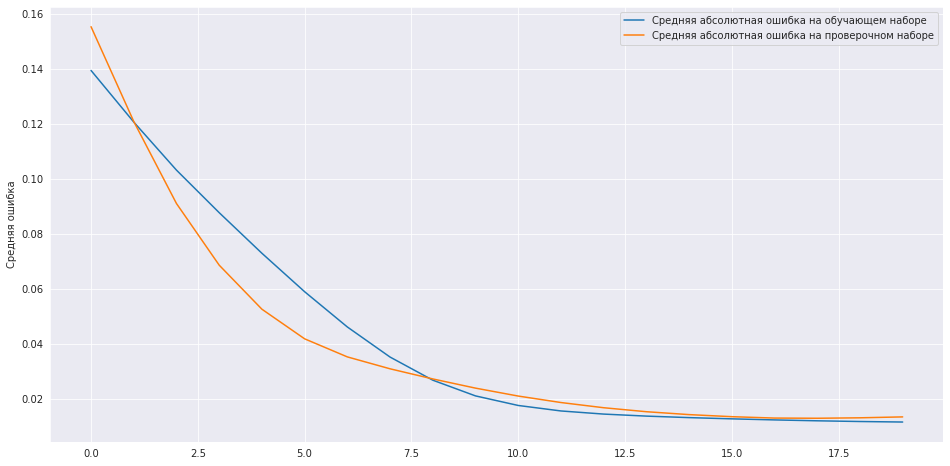

In [40]:
callbaсk = EarlyStopping(monitor='val_mae', patience=2)

model = Sequential()

model.add(LSTM(64, input_shape = (inputs.shape[1], inputs.shape[2]), return_sequences="True"))
model.add(Flatten())                       
model.add(Dense(8, activation="linear"))   
model.add(Dense(1, activation="linear"))

model.compile(loss="mse", optimizer="adam", metrics=['mae'])

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[callbaсk, tensorboard_callback])

plt.figure(figsize=(16, 8))
plt.plot(history.history['mae'][1:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'][1:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [43]:
pred = model.predict(dataset_train).flatten()
predVal = model.predict(dataset_val).flatten()

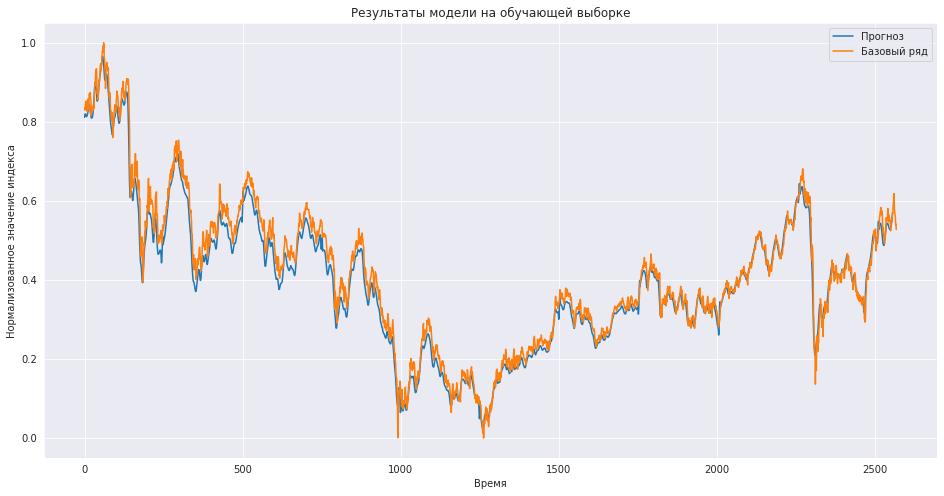

In [42]:
start = 0
plt.figure(figsize=(16,8))
plt.grid('on')
plt.plot(pred[start:train_split], 
         label='Прогноз')
plt.plot(yTrain.flatten()[start:train_split], 
         label='Базовый ряд')
plt.title('Результаты модели на обучающей выборке')
plt.xlabel('Время')
plt.ylabel('Нормализованное значение индекса')
plt.legend()
plt.show()

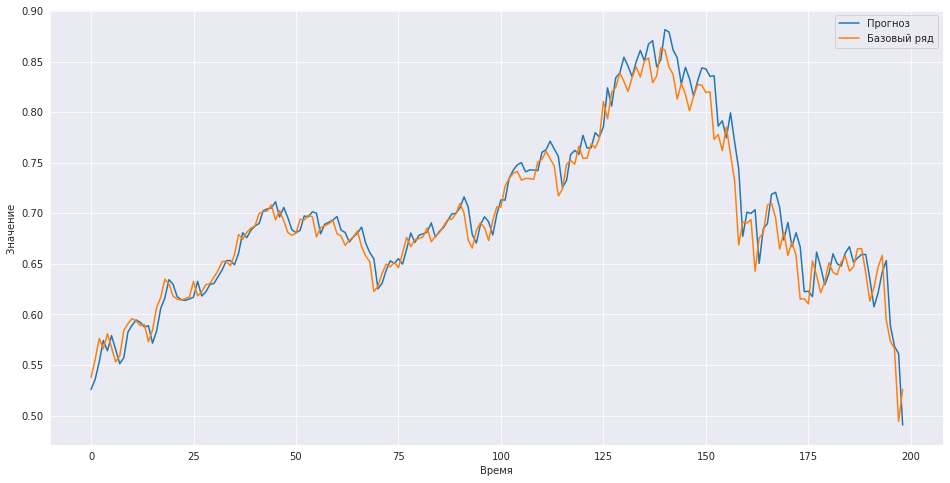

In [44]:
start = 0
step = predVal.shape[0]
plt.figure(figsize=(16,8))
plt.grid('on')
plt.plot(predVal[start:start+step], 
         label='Прогноз')
plt.plot(yVal.flatten()[start:start+step], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

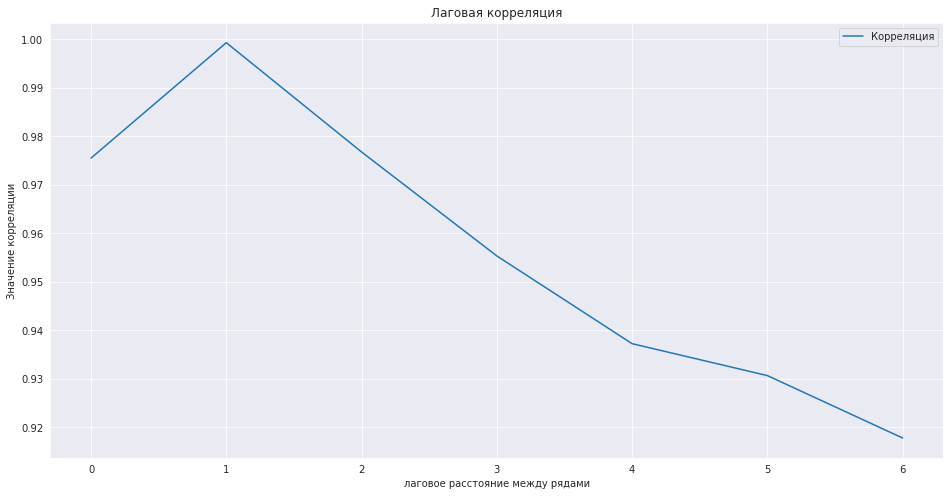

In [45]:
corr = []
start = 0 
step = predVal.shape[0]
h=0
yLen = yVal.shape[0]
yValF = yVal[start:start+step].flatten() 
yPredVal = predVal[start:start+step]

for i in range(7):
  corr.append(correlate(yValF[:-1-i], yPredVal[i:-1]))

plt.figure(figsize=(16,8))
plt.plot(corr, 
         label='Корреляция')
plt.xlabel('лаговое расстояние между рядами')
plt.ylabel('Значение корреляции')
plt.title('Лаговая корреляция')
plt.legend()
plt.show()

Длина истории = 21:

In [46]:
# список признаков, по которым будем учить
channelIndexes = [0, 1, 2]

# длина теста
valLen = 200
# длина истории для работы
xLen = 21
# отступ тестов от тренировок
bias = 10

# вычисляем точку разделения ряда на тесты и тренировку
train_split = data.shape[0] - valLen - bias
# делим
train_data = data.iloc[0 : train_split ,channelIndexes]
val_data = data.iloc[train_split+bias:,channelIndexes]

In [47]:
# шаг по данным для построения обучающих примеров
step = 1

# длина прошлого 
past = xLen
p = past
# горизонт предсказания
future = 1
h=future

# параметры модели для обучения
learning_rate = 1e-3
batch_size = 32
epochs = 100


Chanel_numb = len(channelIndexes)

start = xLen + future
end = start + train_split-1

xTrain_df = train_data.iloc[:-future-xLen+1,:] # сдвиг по времени для предсказания (закончить чуть раньше)
xTrain = xTrain_df[[train_data.columns[i] for i in range(Chanel_numb)]].values
yTrain = train_data.iloc[future+xLen-1:,0].values  # сдвиг по времени для предсказания (начать чуть позднее)

sequence_length = int(xLen / step)


x_end = len(val_data) - xLen - future 

label_start = len(train_data)+bias+xLen + future +1

xVal_df = val_data.iloc[:-future-xLen+1,:] # сдвиг по времени для предсказания (закончить чуть раньше)
xVal = xVal_df[[val_data.columns[i] for i in range(Chanel_numb)]].values
yVal = val_data.iloc[future+xLen-1:,0].values  # сдвиг по времени для предсказания (начать чуть позднее)

In [48]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    xTrain,
    yTrain,
    sequence_length=xLen,
    sampling_rate=1,
    batch_size=batch_size,
)
dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    xVal,
    yVal,
    sequence_length=xLen,
    sampling_rate=1,
    batch_size=batch_size,
)

for batch in dataset_val.take(2):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (32, 21, 3)
Target shape: (32,)


Epoch 1/100
80/80 [==============================] - 4s 26ms/step - loss: 0.0504 - mae: 0.1300 - val_loss: 0.0334 - val_mae: 0.1757
Epoch 2/100
80/80 [==============================] - 2s 19ms/step - loss: 0.0140 - mae: 0.0915 - val_loss: 0.0311 - val_mae: 0.1693
Epoch 3/100
80/80 [==============================] - 2s 21ms/step - loss: 0.0156 - mae: 0.0835 - val_loss: 0.0196 - val_mae: 0.1316
Epoch 4/100
80/80 [==============================] - 2s 22ms/step - loss: 0.0062 - mae: 0.0563 - val_loss: 0.0176 - val_mae: 0.1245
Epoch 5/100
80/80 [==============================] - 2s 21ms/step - loss: 0.0060 - mae: 0.0539 - val_loss: 0.0151 - val_mae: 0.1145
Epoch 6/100
80/80 [==============================] - 2s 23ms/step - loss: 0.0054 - mae: 0.0513 - val_loss: 0.0151 - val_mae: 0.1149
Epoch 7/100
80/80 [==============================] - 2s 20ms/step - loss: 0.0055 - mae: 0.0509 - val_loss: 0.0136 - val_mae: 0.1090
Epoch 8/100
80/80 [==============================] - 2s 24ms/step - loss: 0.

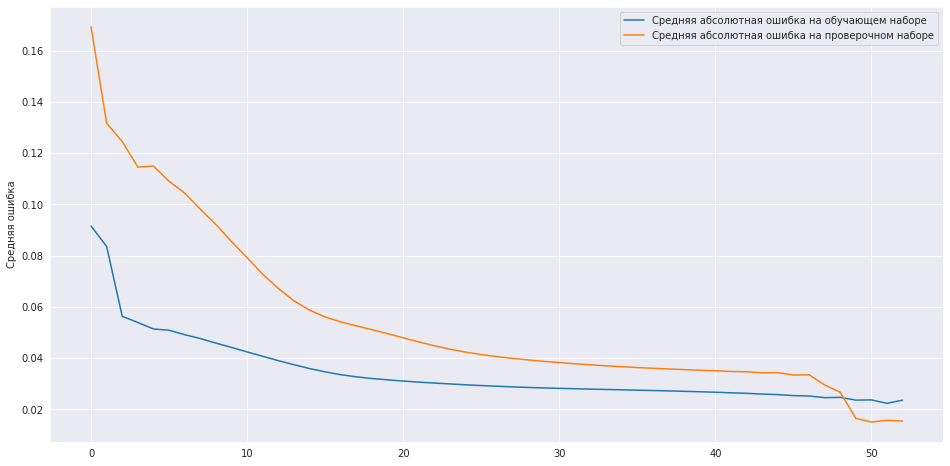

In [54]:
callbaсk = EarlyStopping(monitor='val_mae', patience=2)

model = Sequential()

model.add(LSTM(32, input_shape = (inputs.shape[1], inputs.shape[2]), return_sequences="True"))
model.add(Conv1D(32, 3, activation="linear"))
model.add(Flatten())                       
model.add(Dense(4, activation="linear"))   
model.add(Dense(1, activation="linear"))

model.compile(loss="mse", optimizer="adam", metrics=['mae'])

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[callbaсk, tensorboard_callback])

plt.figure(figsize=(16, 8))
plt.plot(history.history['mae'][1:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'][1:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [61]:
pred = model.predict(dataset_train).flatten()
predVal = model.predict(dataset_val).flatten()

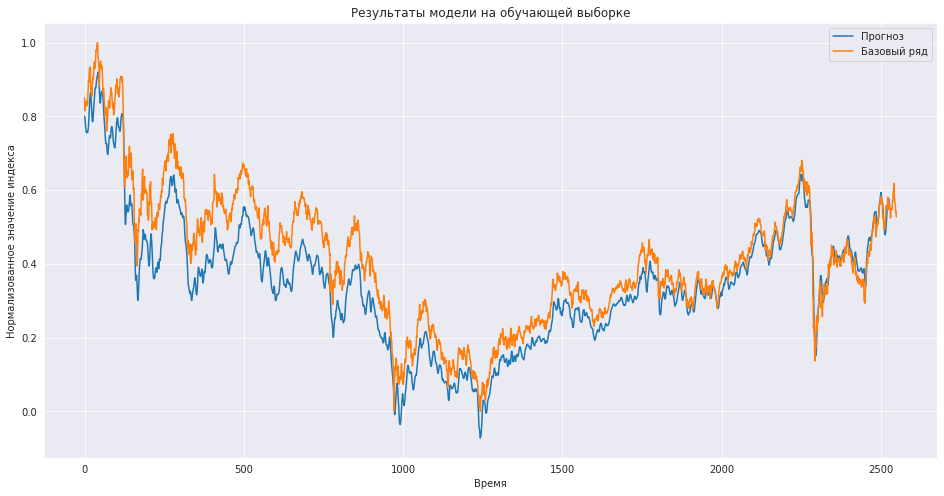

In [62]:
start = 0
plt.figure(figsize=(16,8))
plt.grid('on')
plt.plot(pred[start:train_split], 
         label='Прогноз')
plt.plot(yTrain.flatten()[start:train_split], 
         label='Базовый ряд')
plt.title('Результаты модели на обучающей выборке')
plt.xlabel('Время')
plt.ylabel('Нормализованное значение индекса')
plt.legend()
plt.show()

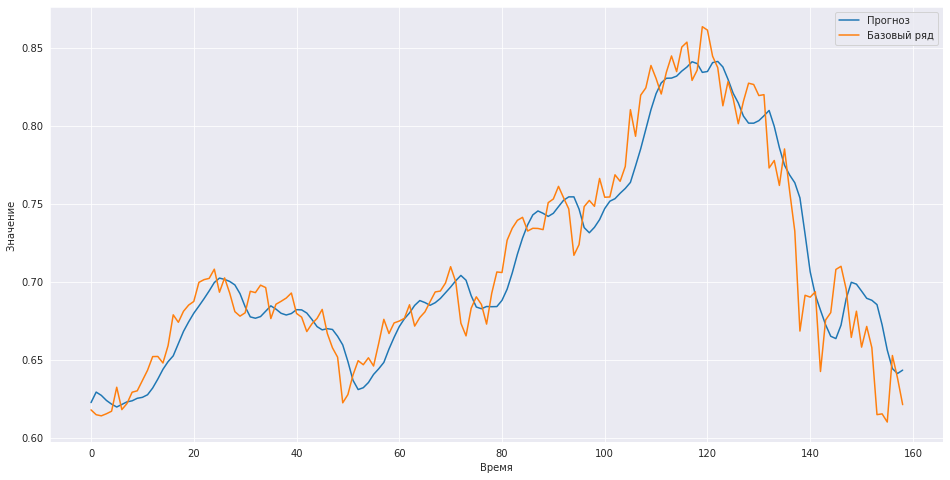

In [63]:
start = 0
step = predVal.shape[0]
plt.figure(figsize=(16,8))
plt.grid('on')
plt.plot(predVal[start:start+step], 
         label='Прогноз')
plt.plot(yVal.flatten()[start:start+step], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

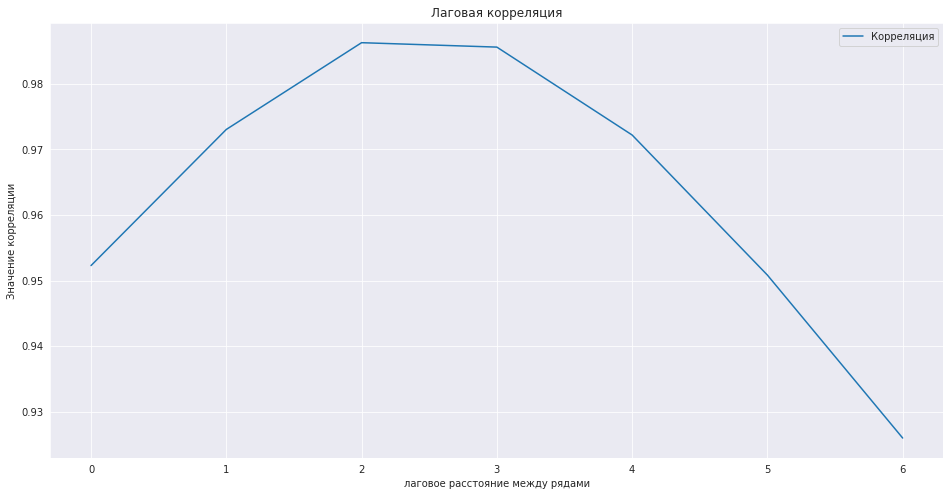

In [64]:
corr = []
start = 0 
step = predVal.shape[0]
h=0
yLen = yVal.shape[0]
yValF = yVal[start:start+step].flatten() 
yPredVal = predVal[start:start+step]

for i in range(7):
  corr.append(correlate(yValF[:-1-i], yPredVal[i:-1]))

plt.figure(figsize=(16,8))
plt.plot(corr, 
         label='Корреляция')
plt.xlabel('лаговое расстояние между рядами')
plt.ylabel('Значение корреляции')
plt.title('Лаговая корреляция')
plt.legend()
plt.show()

__Задание 3.__

Насколько я понимаю, кроме специально созданных блоков LSTM и GRU, которые призваны решить проблему исчезающего градиента существует еще несколько подходов.

Один из них - это обрезание градиента, то есть задание неких границ выше/ниже которых он не может быть при переходе между слоями. В первую очередь этот метод используется при взрывающемся градиенте, однако мне кажется он может работать и в обратную сторону тоже. Можно установить определенный нижний предел для значения градиента, чтобы он не затухал слишком быстро при обратном распространении.

Другой подход для решения этой проблемы - это создание сети, в которой будут существовать так называемые обходные пути, которые будут соединять некоторые нейроны с другими непоследовательно, а минуя несколько слоев. При обратном распостранении это позволит уменьшить количество умножений производных и таким образом уменьшит риск затухания градиента. Примеры сетей: **ResNet**, **HighwayNet**, DenseNet. В последней все слои соединены со всеми остальными.